In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from PIL import Image
%matplotlib inline

## 1. Description

In [3]:
y = pd.read_csv("./data/train_labels.csv")
print(y.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


In [6]:
print(f"The size of data: {y.shape[0]}")
print(f"Label counts:\n{y['label'].value_counts()}")
print("Train Size: {}".format(len(os.listdir('./data/train/'))))
print("Test Size: {}".format(len(os.listdir('./data/test/'))))

The size of data: 220025
Label counts:
label
0    130908
1     89117
Name: count, dtype: int64
Train Size: 220025
Test Size: 57458


Histopathologic Cancer Detection involves classifying images of tissue samples to determine whether they contain cancerous cells. This is typically framed as a binary classification problem, where: 

- Label 0 indicates non-cancerous tissue
- Label 1 indicates cancerous tissue

Based on the provided data:

1. Training Data: 220025
   - Training labels:

      - Non-cancerous (Label 0): 130908
      - Cancerous (Label 1): 89117
2. Test Data: 57458

## 2. EDA

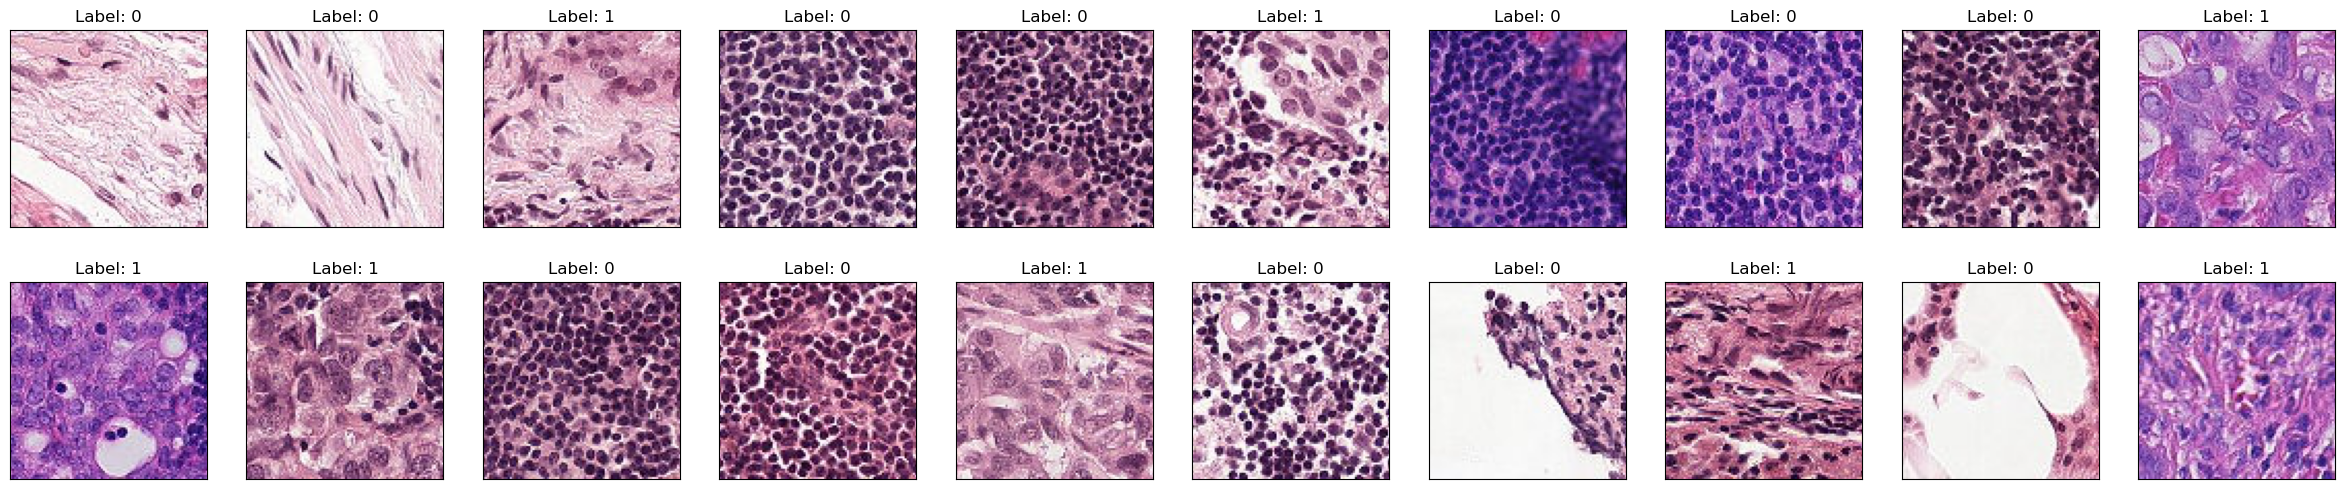

In [30]:
def visualize_samples(image_ids, labels, base_dir='./data/train/'):
    fig = plt.figure(figsize=(30, 6))
    for i, image_id in enumerate(image_ids):
        img = Image.open(os.path.join(base_dir, f'{image_id}.tif'))
        ax = fig.add_subplot(2, 20//2, i+1, xticks=[], yticks=[])
        plt.imshow(img)
        ax.set_title(f"Label: {labels.iloc[i]}")

# Visualize a few samples from the dataset
sample_images = y.sample(20)
visualize_samples(sample_images['id'], sample_images['label'])

In [ ]:
class HistopathologicCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0] + '.tif')
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

# Image transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 3. Architecture